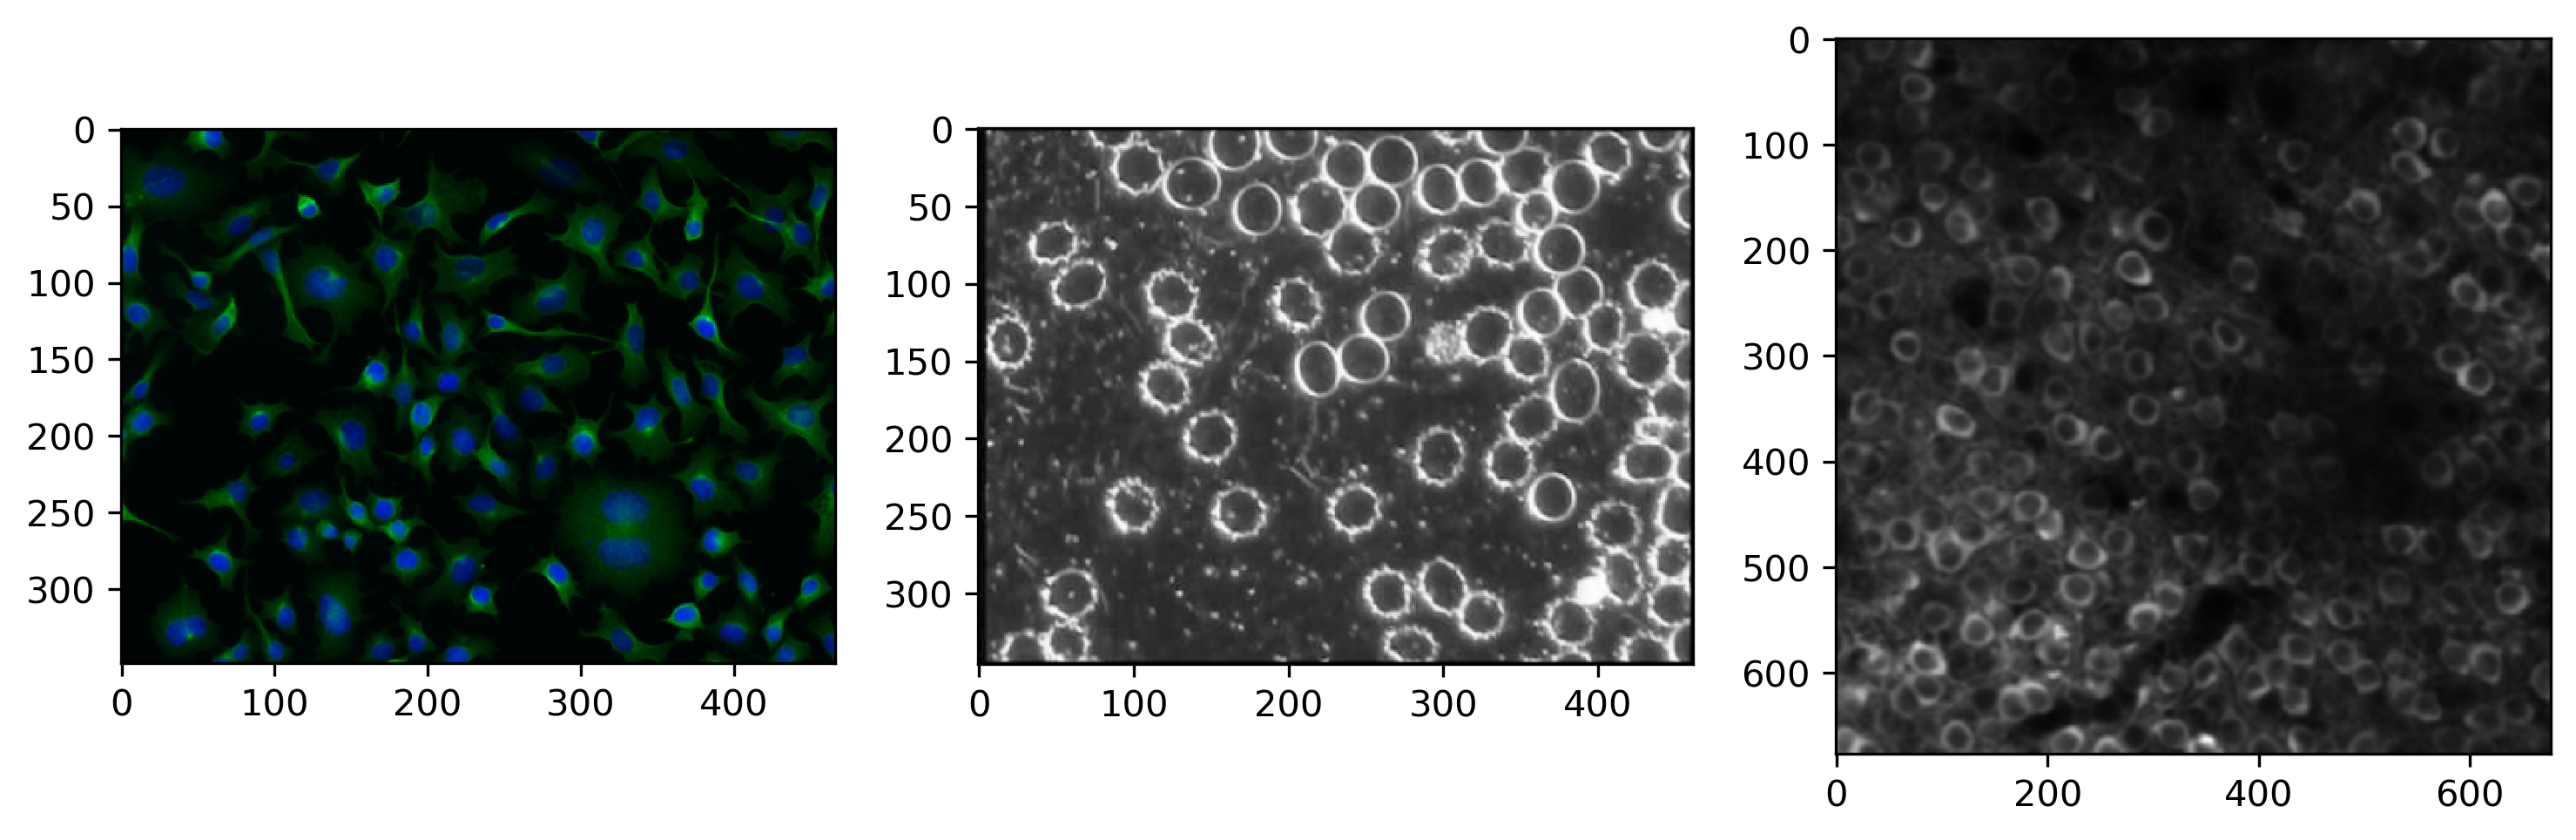

In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils

# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(12,4))
for k,img in enumerate(imgs):
    plt.subplot(1,3,k+1)
    plt.imshow(img)

In [76]:
from cellpose import models
from cellpose import transforms
from mxnet import ndarray as nd
from mxnet.gluon import nn

model0 = models.Cellpose(net_avg=False, batch_size=1)


>>>> using CPU


In [13]:
cpnet = model0.cp.net

In [29]:
img = imgs[0][...,2]
print(img.shape)
# plt.imshow(img, cmap='magma')

(349, 467)


In [33]:
x = transforms.reshape(img, channels=0)
x.shape

(2, 349, 467)

In [26]:
# x = np.transpose(img, (2,0,1))
# print(img.shape, x.shape)

model0.device

In [34]:
IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(x, bsize=224)
IMG = nd.array(IMG, ctx=model0.device)
IMG.shape

(12, 2, 224, 224)

In [ ]:
# cpnet.hybridize()
# cpnet.collect_params().initialize()
# cpnet

In [39]:
y, style = cpnet(IMG[0:1])
y.shape, style.shape

((1, 3, 224, 224), (1, 256))

## get hidden layer outputs
https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb

In [60]:
cpnet.summary

<bound method Block.summary of CPnet(
  (downsample): downsample(
    (down): HybridSequential(
      (0): resdown(
        (conv): HybridSequential(
          (0): HybridSequential(
            (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=2)
            (1): Activation(relu)
            (2): Conv2D(2 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): HybridSequential(
            (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
            (1): Activation(relu)
            (2): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (2): HybridSequential(
            (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
            (1): Activation(relu)
            (2): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
         

In [55]:
cpnet.downsample.summary

<bound method Block.summary of downsample(
  (down): HybridSequential(
    (0): resdown(
      (conv): HybridSequential(
        (0): HybridSequential(
          (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=2)
          (1): Activation(relu)
          (2): Conv2D(2 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): HybridSequential(
          (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
          (1): Activation(relu)
          (2): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): HybridSequential(
          (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
          (1): Activation(relu)
          (2): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (3): HybridSequential(
          (0): BatchNorm(axis=1, eps=

In [59]:
cpnet.make_style.summary

<bound method Block.summary of make_style(
  (pool_all): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
  (flatten): Flatten
)>

In [52]:
down = cpnet.downsample(IMG[0:1])
len(down)

4

In [57]:
down[0].shape, down[1].shape, down[2].shape, down[3].shape

((1, 32, 224, 224), (1, 64, 112, 112), (1, 128, 56, 56), (1, 256, 28, 28))

In [61]:
s = cpnet.make_style(down[-1])
s.shape

(1, 256)

In [62]:
style.shape

(1, 256)

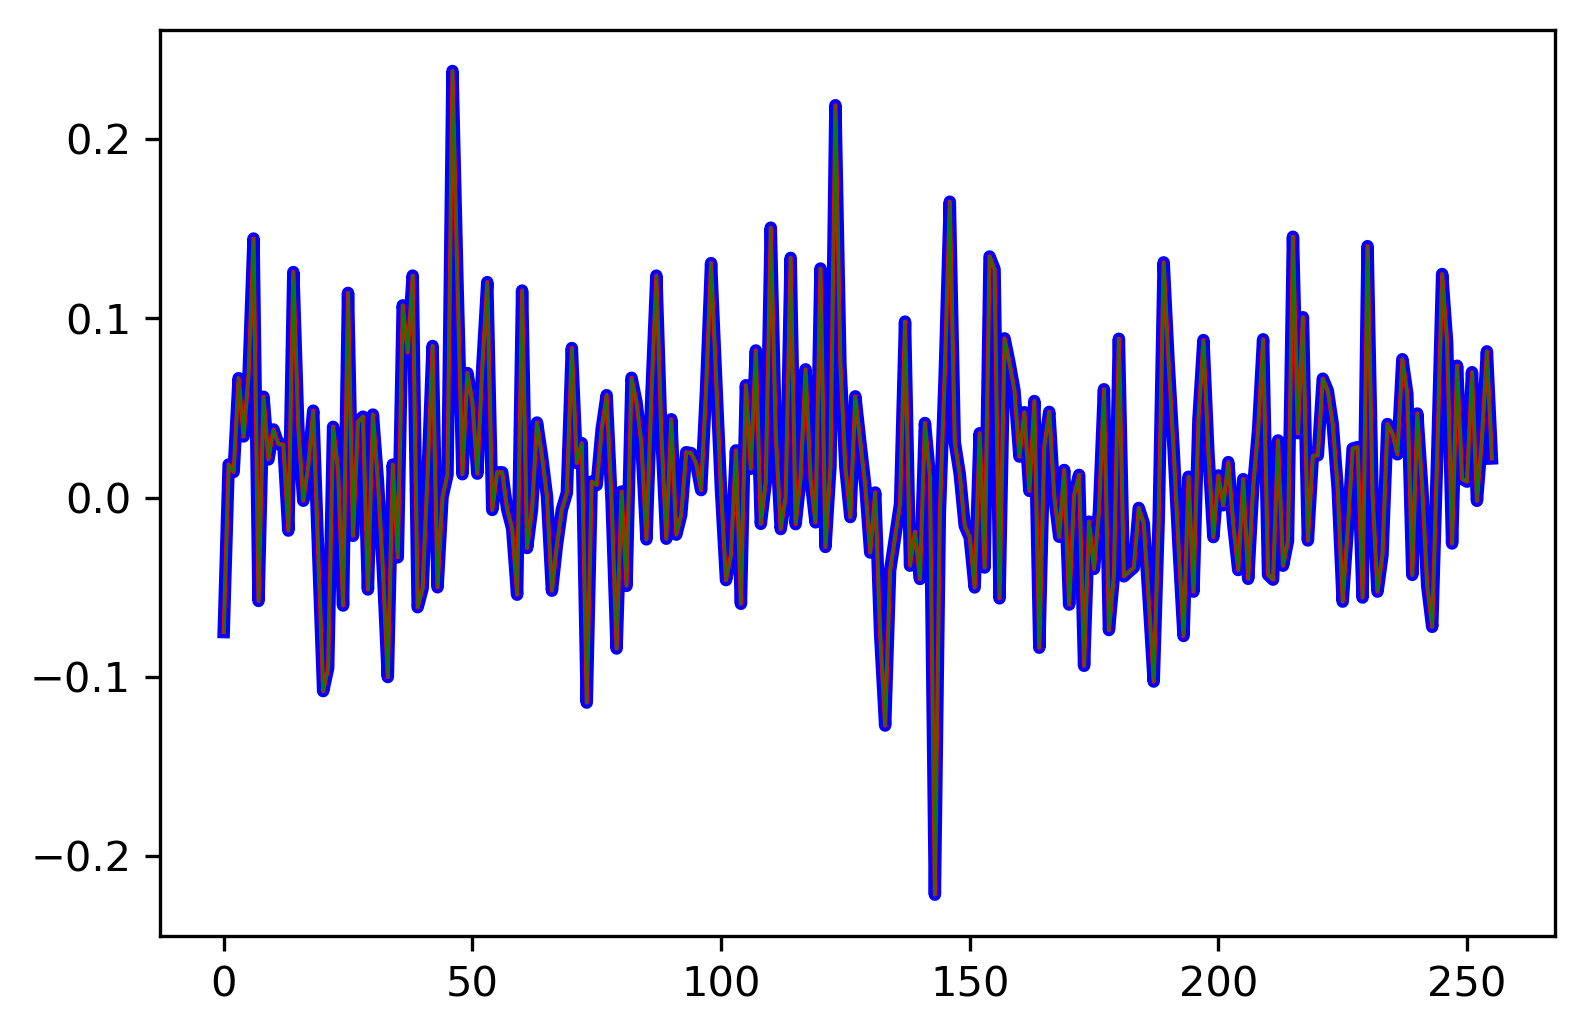

In [88]:
plt.plot(range(0,256), style[0,:].asnumpy(), color='b', linewidth=3)
plt.plot(range(0,256), s[0,:].asnumpy(), color='r', linewidth=1)
plt.plot(range(0,256), dmean_norm[0,:], color='g', linewidth=.5)
plt.show()


In [79]:
d = down[-1].asnumpy()
d.shape

(1, 256, 28, 28)

In [81]:
dmean = d.mean(axis=(2,3))
dmean.shape

(1, 256)

In [86]:
var = np.sqrt((dmean.flatten()**2).sum())
dmean_norm = dmean/var
dmean_norm.shape

(1, 256)